# Imports

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

# Conhecendo os datasets

In [0]:
# read the datasets
dfs = {
    'train': pd.read_csv("train.csv"),
    'test': pd.read_csv("test.csv"),
}
df_train = dfs['train'].copy()
df_test = dfs['test'].copy()

In [0]:
print("train:= shape=", df_train.shape)
print("test:= shape=", df_test.shape)
print("=====================================")
print("train columns", df_train.columns)
print("test columns", df_test.columns)

train:= shape= (9000, 26)
test:= shape= (1000, 25)
train columns Index(['host_response_time', 'host_response_rate', 'host_neighbourhood',
       'host_listings_count', 'neighbourhood', 'city', 'state', 'zipcode',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'security_deposit',
       'cleaning_fee', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'reviews_per_month',
       'price'],
      dtype='object')
test columns Index(['host_response_time', 'host_response_rate', 'host_neighbourhood',
       'host_listings_count', 'neighbourhood', 'city', 'state', 'zipcode',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'security_deposit',
       'cleaning_fee', 'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'reviews_per

In [0]:
geolocator = Nominatim(user_agent="imd-prova")

## Manipulações prévias

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 26 columns):
host_response_time      6489 non-null object
host_response_rate      6489 non-null object
host_neighbourhood      6344 non-null object
host_listings_count     8997 non-null float64
neighbourhood           8748 non-null object
city                    8988 non-null object
state                   8990 non-null object
zipcode                 8603 non-null object
latitude                9000 non-null float64
longitude               9000 non-null float64
property_type           9000 non-null object
room_type               9000 non-null object
accommodates            9000 non-null int64
bathrooms               8984 non-null float64
bedrooms                8995 non-null float64
beds                    8994 non-null float64
bed_type                9000 non-null object
security_deposit        5999 non-null object
cleaning_fee            7254 non-null object
extra_people            9000 non-

In [0]:
df_train.head()

,host_response_time,host_response_rate,host_neighbourhood,host_listings_count,neighbourhood,city,state,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,price
0,within an hour,84%,Ipanema,12.0,Ipanema,Rio De Janeiro,Rj,22411-002,-22.98262,-43.20720,Apartment,Entire home/apt,4,2.0,2.0,2.0,Real Bed,$500.00,$130.00,$23.00,2,1125,21,81.0,0.32,309.0
1,within a day,50%,Barra da Tijuca,1.0,Barra da Tijuca,Barra da Tijuca,Rio de Janeiro,22630-010,-23.01124,-43.32676,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,NaN,NaN,$0.00,1,1125,5,88.0,1.15,351.0
2,within an hour,99%,Ipanema,340.0,Copacabana,Copacabana,Rio de Janeiro,22081-010,-22.98264,-43.19115,Apartment,Entire home/apt,8,3.5,3.0,7.0,Real Bed,"$1,000.00",$190.00,$48.00,4,1125,1,100.0,0.06,398.0
3,within a few hours,100%,Lagoa,7.0,Lagoa,Rio de Janeiro,Rio de Janeiro,22061,-22.97651,-43.19890,Apartment,Entire home/apt,10,3.0,3.0,6.0,Real Bed,"$1,972.00",$498.00,$174.00,3,120,7,94.0,0.13,849.0
4,within a day,75%,Joá,4.0,Joá,Rio de Janeiro,RJ,22611-021,-23.00995,-43.28959,House,Entire home/apt,2,1.5,1.0,2.0,Real Bed,NaN,NaN,$100.00,2,9,1,100.0,0.09,70.0


Pelo método **head()**, podemos ver que devemos realizar alguns tratamentos nas colunas:
```python
[
  'host_response_rate',
  'state',
  'zipcode',
  'security_deposit',
  'cleaning_fee',
  'extra_people',
  'host_response_rate',
  'host_response_rate',
  'host_response_rate',
]
```

In [0]:
# Atualizando os valores relacionados a localização
def get_location_info(row):
  location = geolocator.reverse((row['latitude'], row['longitude']))
  location_data = location[0].split(", ")
  print(len(location_data), location_data)
  data_return = {
    'neighbourhood': location_data[2],
    'city': location_data[4],
    'state': location_data[7],
    'zipcode': location_data[9],
  }
  return data_return

In [0]:
row_fake = {
    'latitude': -22.98264,
    'longitude': -43.19115,
}

# print( get_location_info(row_fake) )
df_train.apply(get_location_info, axis=1)

12 ['Maria e o Boi', '111', 'Rua Maria Quitéria', 'Lagoa', 'Zona Sul do Rio de Janeiro', 'Rio de Janeiro', 'Microrregião Rio de Janeiro', 'Região Metropolitana do Rio de Janeiro', 'RJ', 'Região Sudeste', '22420-040', 'Brasil']
12 ['Radisson Hotel Barra', '3150', 'Avenida Lúcio Costa', 'Barra da Tijuca', 'Zona Oeste do Rio de Janeiro', 'Rio de Janeiro', 'Microrregião Rio de Janeiro', 'Região Metropolitana do Rio de Janeiro', 'RJ', 'Região Sudeste', '22630-010', 'Brasil']
11 ['Copacabana Rio Hotel', 'Avenida Nossa Senhora de Copacabana', 'Copacabana', 'Zona Sul do Rio de Janeiro', 'Rio de Janeiro', 'Microrregião Rio de Janeiro', 'Região Metropolitana do Rio de Janeiro', 'RJ', 'Região Sudeste', '22060-000', 'Brasil']
10 ['Avenida Henrique Dodsworth', 'Lagoa', 'Zona Sul do Rio de Janeiro', 'Rio de Janeiro', 'Microrregião Rio de Janeiro', 'Região Metropolitana do Rio de Janeiro', 'RJ', 'Região Sudeste', '22061-040', 'Brasil']


## Encontrando outlier
A intenção aqui é descobrir onde há outlier e, após isso, retira-los do nosso dataset. Usaremos a biblioteca **matplotlib** para nos ajudar nessa etapa de exploração.

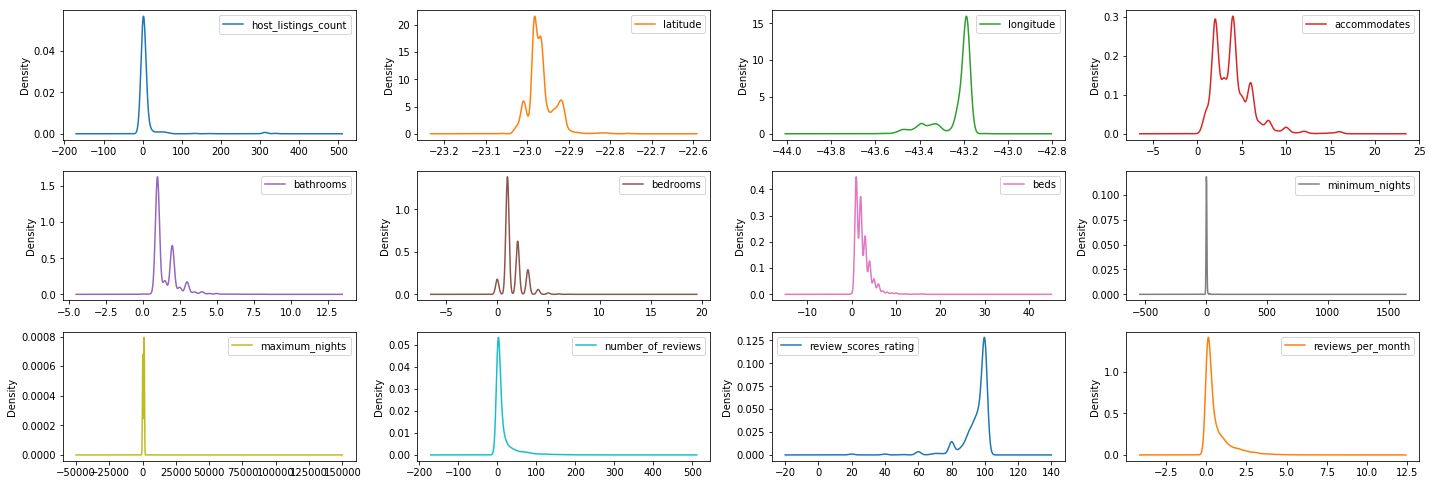

In [0]:
df_train[df_test.columns].plot(kind="density",
          subplots=True,
          sharex=False,
          layout=(9,4),
          figsize=(20,20))
plt.tight_layout()
plt.show()

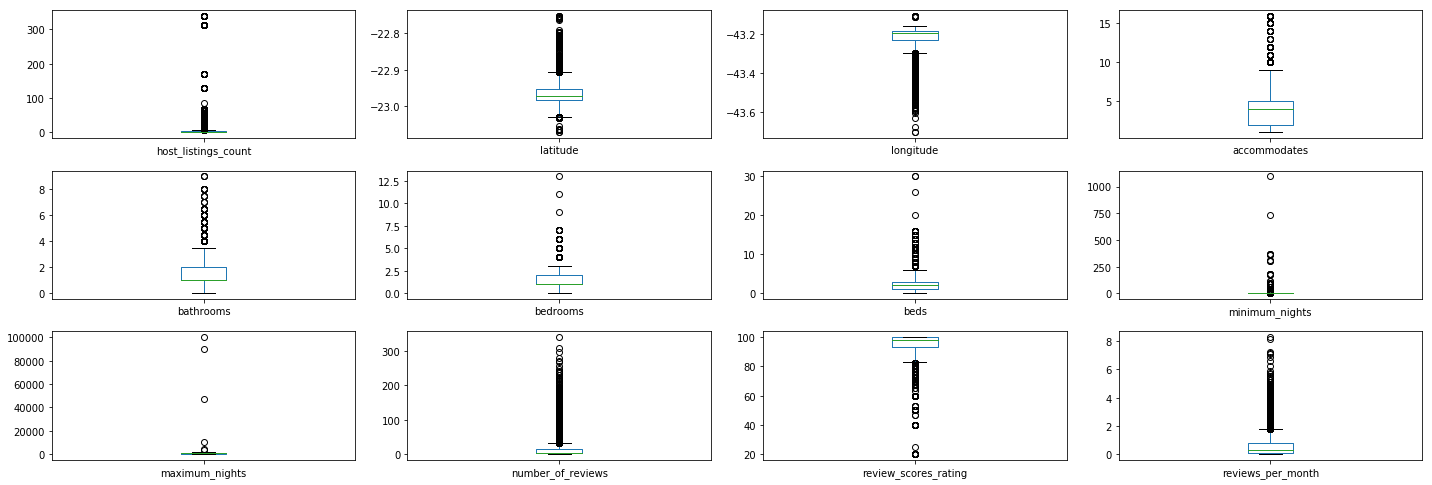

In [0]:
df_train[df_test.columns].plot(kind="box",
          subplots=True,
          sharex=False,
          layout=(9,4),
          figsize=(20,20))
plt.tight_layout()
plt.show()

## Limpando, preparando e manipulando os dados

In [0]:
from sklearn.preprocessing import StandardScaler

def clean_outliers(data, algorithm='iqr'):
  df = data.copy()
  if algorithm == "iqr":
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    up = Q3 + 1.5 * IQR
    df = df[((df > low).all(axis=1) & (df < up).all(axis=1))]
  elif algorithm == "z-score":
    df = pd.DataFrame(StandardScaler().fit_transform(df),
                            columns=df.columns,
                            index=df.index)
    df = df[(df < 2.698).all(axis=1) & (df > -2.698).all(axis=1)]
  return df

In [0]:
train_iqr = clean_outliers(df_train,"iqr")
train_z_score = clean_outliers(df_train,"z-score")

ValueError: ignored

Usaremos o método **info()** para termos uma melhor noção do que arrumar nosso dataset para melhor treinar.

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 26 columns):
host_response_time      6489 non-null object
host_response_rate      6489 non-null object
host_neighbourhood      6344 non-null object
host_listings_count     8997 non-null float64
neighbourhood           8748 non-null object
city                    8988 non-null object
state                   8990 non-null object
zipcode                 8603 non-null object
latitude                9000 non-null float64
longitude               9000 non-null float64
property_type           9000 non-null object
room_type               9000 non-null object
accommodates            9000 non-null int64
bathrooms               8984 non-null float64
bedrooms                8995 non-null float64
beds                    8994 non-null float64
bed_type                9000 non-null object
security_deposit        5999 non-null object
cleaning_fee            7254 non-null object
extra_people            9000 non-

As colunas que iremos tratar serão:
```python
[
  host_response_time      6489 non-null object
  host_response_rate      6489 non-null object
  host_neighbourhood      6344 non-null object
  host_listings_count     8997 non-null float64
  neighbourhood           8748 non-null object
  city                    8988 non-null object
  state                   8990 non-null object
  zipcode                 8603 non-null object
  bathrooms               8984 non-null float64
  bedrooms                8995 non-null float64
  beds                    8994 non-null float64
  security_deposit        5999 non-null object
  cleaning_fee            7254 non-null object
]
```

In [0]:
columns_train = [
    'host_response_time', 'host_response_rate',
    'host_neighbourhood', 'host_listings_count',
    'neighbourhood', 'city',
    'state', 'zipcode',
    'bathrooms', 'bedrooms',
    'beds', 'security_deposit',
    'cleaning_fee',
]
df_train[columns_train].head()


0     84%
1     50%
2     99%
3    100%
4     75%
Name: host_response_rate, dtype: object

In [0]:
# instantiate a knn object
knn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

X = train.drop(labels="price",axis=1)
y = train["price"]

# train the model
knn.fit(X[["accommodates","minimum_nights"]],y)

# predict
predict = knn.predict(test[["accommodates","minimum_nights"]])

ValueError: ignored

In [0]:
# prepare a submission file
submission_df = {"id": test.index, "price": predict}
submission = pd.DataFrame(submission_df)
submission.to_csv("submission.csv",index=False)

In [0]:
files.download("submission.csv")